In [1]:
import numpy as np
import pickle
import pywt
import matplotlib.pyplot as plt

## Load Data

In [2]:
data = np.zeros([32,40,40,8064])
labels = np.zeros([32,40,4])

for i in range(1, 33):
    if i < 10:
        file = "./data_preprocessed_python/s{0}.dat".format("0" + str(i))
    else:
        file = "./data_preprocessed_python/s{0}.dat".format(str(i))
    with open(file, 'rb') as f: 
        content = pickle.load(f, encoding= "latin1")
    data[i-1,:,:,:] = content["data"]
    labels[i-1,:,:] = content["labels"]

In [3]:
# 32 subjects that watched 40 videos each with 40 sensors (32 EEG + peripherals) for 60s at 128 Hz
data.shape

(32, 40, 40, 8064)

In [4]:
# 32 subjects that watched 40 videos each that have 4 emotional labels per video
labels.shape

(32, 40, 4)

In [5]:
#segregate into just EEG Data, cut the first 3 seconds that was the baseline (CHECK THIS, waiting on email)
eeg_data = data[:,:,:32,128 * 3:]
eeg_data.shape

(32, 40, 32, 7680)

In [6]:
#split into 6 second intervals. So now 32 individuals who watched 40 videos with 32 EEG sensors and each video is 
#broken up into 10 6 second recording chunks
eeg_data = np.array(np.array_split(eeg_data, 10, axis = 3)).transpose(1,2,3,0,4)
eeg_data.shape

#split into training and test data (TODO in the future)

(32, 40, 32, 10, 768)

## Pre-Processing

In [7]:
#http://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html
#Bandpass filtering and downsampling already done for this dataset!

## Data Compression

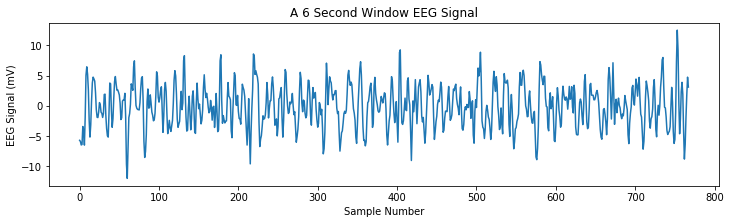

In [138]:
x = eeg_data[0,0,0,6,:] #test sample

plt.figure(figsize=(12,3))
plt.plot(x)
plt.ylabel("EEG Signal (mV)")
plt.xlabel("Sample Number")
plt.title("A 6 Second Window EEG Signal");

In [29]:
#dictionary (D) we should be using is inverse db5 WT matrix
#seems like we want to use idwt from pywt with 'db5'

# y = Phi * D * z
# y is compressed data
# Phi is sensing matrix 
# D is inverse db5 WT matrix
# z is D_inv * x, where D_inv is the db5 WT matrix and x is the EEG signal. I think. 

#ok so what I'm understanding is we want to run CS on y = Az to recover z, where A is Phi.dot(D). Then we
#can recover x by doing the wavelet transform on z. 

#later when we want to do reconstruction-free CS, we want to just recover y and then do DWT on y, then apply
#ml algorithms

In [120]:
levels = 6

## Wavelet functions below
## Note: we expect all image sizes to be powers-of-two and square!
## So if you adapt this code, be sure to fix this or enforce this requirement...

# Get a default slice object for a multilevel wavelet transform
# Used to abstract this annoying notation out of the transform...
def default_slices(levels, n):
    c = pywt.wavedec(np.zeros((n,)), 'db5', level=levels)
    bye, slices = pywt.coeffs_to_array(c)
    return slices

# Wrapper for forward discrete wavelet transform
# Output data as a matrix (we don't care about tuple format)
def dwt(levels, sdom_data):
    c = pywt.wavedec(sdom_data, 'db5', level=levels)
    output, slices = pywt.coeffs_to_array(c)
    return output, slices

# Wrapper for inverse discrete wavelet transform
# Expect wdom_data as a matrix (we don't care about tuple format)
def idwt(levels, wdom_data, slices=None):
    n = wdom_data.shape[0]
    if slices is None:
        slices = default_slices(levels, n)
    c = pywt.array_to_coeffs(wdom_data, slices, output_format='wavedec')
    return pywt.waverec(c, 'db5')

def meas_map(mtx, Phi, slices=None):
    pre_proj = idwt(levels, mtx, slices)
    y = Phi.dot(pre_proj)
    return y

def meas_map_adj(mtx, Phi):
    mtx = mtx.dot(Phi)
    output, slices = dwt(levels, mtx)
    return output

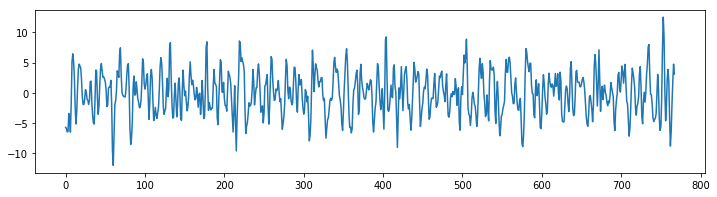

In [89]:
#check that dwt and idwt make sense here

forward, forward_slices = dwt(levels, x)
backward = idwt(levels, forward, forward_slices)

plt.figure(figsize=(12,3))
plt.plot(backward);

In [136]:
# 0.2

def complex_l1_prox(s, lam):
    phases = np.angle(s)
    mags = np.abs(s)
    thresholded = l1_prox_matrix(mags, lam)
    return thresholded * np.exp(1j * phases)

def l1_prox_matrix(s, lam):
    s = s.copy()
    for i in range(s.shape[0]):
        if s[i] > lam:
            s[i] -= lam
        elif s[i] < -1 * lam:
            s[i] += lam
        else:
            s[i] = 0
    return s

def prox_grad_desc(Phi, y, lam, slices, shape):

    s = np.random.normal(size = shape)
    scale = np.linalg.norm(s)
    s = s / scale
    
    s_prev = 0
    diff = np.linalg.norm(s - s_prev)
    alpha = 1 / (np.real(np.sort(np.linalg.eig(Phi.T.dot(Phi))[0])[-1]))

    count = 0
    while diff > 5E-6:
        s_grad = meas_map_adj((meas_map(s, Phi, slices) - y), Phi)
        s_new = s - alpha * s_grad
        s_new = complex_l1_prox(s_new, lam)

        s_prev = s
        s = s_new
        diff = np.linalg.norm(s - s_prev)

        if count % 10000 == 0:
            print(count, diff)
        count += 1
        
    return s

0.1
0 0.041240604295829375
10000 2.3676242560781138e-05
20000 1.9091031022091377e-05
30000 1.5071486325646526e-05
40000 1.0942772249497483e-05
50000 8.00208420928126e-06
60000 6.29019481072429e-06
70000 5.415818320592256e-06
Done
3.448937271716748
0.004470148003484627
149.47056731107725
96.05640382203308
0.2
0 0.03399989369645188
10000 2.4028537367306978e-05
20000 1.9989896228014953e-05
30000 1.695856657146082e-05
40000 1.3006030727994424e-05
50000 9.531777018039533e-06
60000 6.603786954388393e-06
Done
2.258420737773071
0.011776918985858292
149.6226480363838
96.05640382203308
0.3
0 0.02464597127724944
10000 2.4307442032334577e-05
20000 2.1205833855319206e-05
30000 1.799273022144634e-05
40000 1.3500521497680286e-05
50000 1.0208107688354339e-05
60000 6.966624322804256e-06
Done
1.7537685231316245
0.023988927495400235
149.71329951954752
96.05640382203308
0.4
0 0.016166654548078054
10000 2.4417360644067632e-05
20000 2.0609194871013005e-05
30000 1.8165658471899246e-05
40000 1.459512615097189

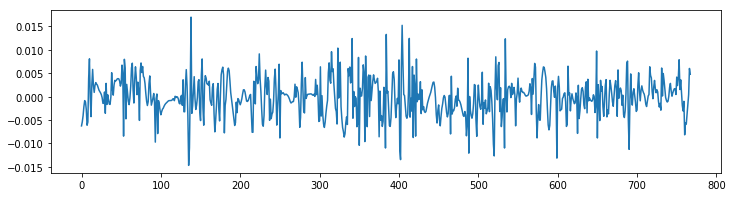

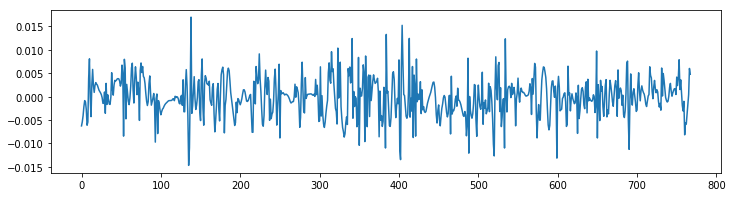

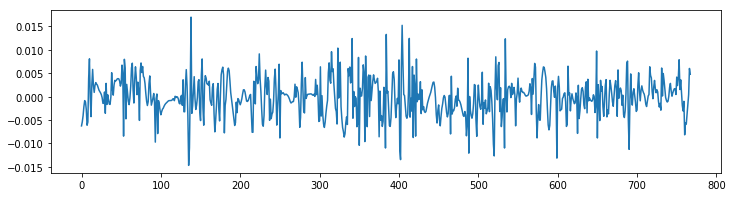

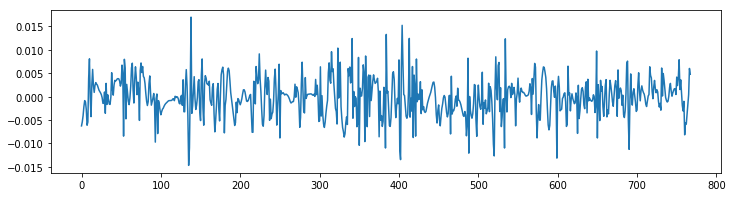

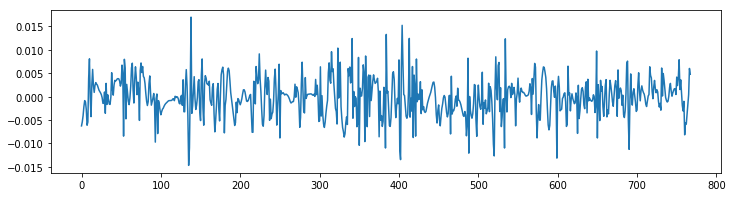

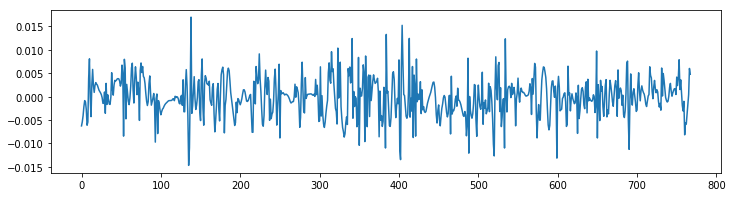

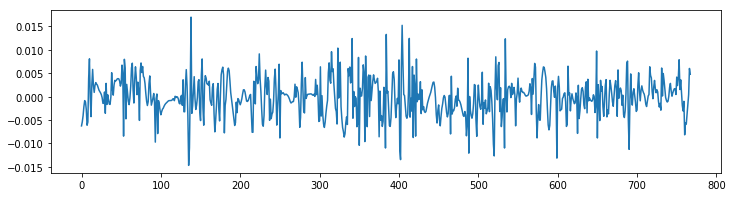

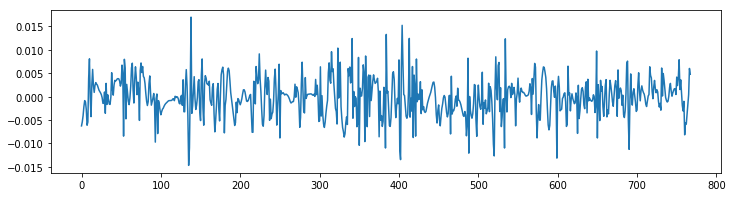

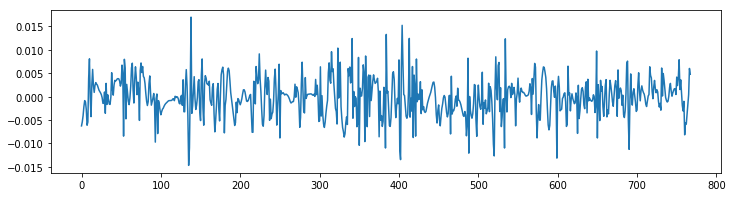

In [137]:
for p in [i / 10 for i in range(1,10)]:
    print(p)
    M = 192
    N = 768
#     p = 0.25

    Phi = np.random.binomial(1, p, size = (M,N))
    s, slices = dwt(levels, x)
    y = meas_map(s, Phi, slices)
    scale = np.linalg.norm(y)
    y = y / scale
    lam = 0.000001


    rec_s = prox_grad_desc(Phi, y, lam, slices, s.shape) 
    rec_x = np.real(idwt(levels, rec_S, slices))

    print("Done")
    print(np.linalg.norm(rec_s, ord = 1))
    print(np.linalg.norm(meas_map(rec_s, Phi, slices) - y, ord = 2))
    print(np.linalg.norm(rec_s - s))
    print(np.linalg.norm(rec_x - x))

    plt.figure(figsize=(12,3))
    plt.plot(rec_x);